In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
cost_mu, cost_sigma = 500, 75

def B(t):
    return cost_mu + cost_sigma*3 *np.sin(2*np.pi/20*t)

def C(t):
    return cost_mu + cost_sigma*3 *(-np.sin(2*np.pi/20*t))

In [7]:
def getRewards(prices_arr):
    k = [None] * len(prices_arr) 
    for i in range(len(prices_arr)):
        if prices_arr[i] == min(prices_arr):
            k[i] = 1
        elif prices_arr[i] == max(prices_arr):
            k[i] = 0
        else:
            k[i] = 0.5
    return k

def bestActionAccumulatedReward(prices_arr, tau):
    a = 0
    for i in range( int(np.ceil(len(prices_arr)/tau)) ):
        if (i+1)*tau <= len(prices_arr):
            current = prices_arr[int(i*tau):int((i+1)*tau-1)]
        else:
            current = prices_arr[int(i*tau):]
        a += np.max(np.sum(current,axis=0))
    return a

In [52]:
T = 2000
K = 2

weight=[1,1]
prob=np.array([1,1])/2
#prob=[[1] * K for x in range(0,T+2)] # 0: use origin, 1: use card

costs=[[0,0]]
rewards=[[0,0]]

rewards_exp3 = 0

gamma = 0.05
tau = 19

z=[]
z_weight=[]

best_action_accumulated_reward = 0
draw = -1

for i in range(1,T+1):
    daily_costs = [B(i), C(i)]
    costs.append(daily_costs)
    rewards.append(getRewards(daily_costs))
    best_action_accumulated_reward = bestActionAccumulatedReward(rewards,tau)
    
    # periodic exp3        
    if(np.mod(i,tau) == 1): # draw round, pick new action
        for arm in range(K):
            prob[arm] = (1 - gamma)*(weight[arm])/np.sum(weight) + gamma/K
        prob=prob/np.sum(prob) # normalize
        draw = int(np.random.choice([0,1], 1, p=prob)) 
        #print((1 - gamma)*(weight[arm])/np.sum(weight),gamma/K,prob)
    
    observed_reward = rewards[i][draw]
    rewards_exp3 += observed_reward # play arm, get a reward
               
    weak_regret = (best_action_accumulated_reward - rewards_exp3) # weak_regret >= 0     
    # observe a regret
    
    if(np.mod(i,tau) == 0): # update round, calculate new weight
        x = observed_reward / prob[draw]
        weight[draw] = weight[draw]*np.exp(gamma*x/K)
        weight= weight / np.sum(weight) # normalize
        for arm in range(K):
            z_weight.append({"t": i, "weight": weight[arm], "legend": chr(int(arm)+65)})
    
    z.append({"t": i, "regret": weak_regret, "regret_mean": weak_regret / i,
              "action": draw, "action_group": chr(draw+65) ,"method": "exp3"})
    #z.append({"t": i, "regret": i,"method": "y=x"})
    
df=pd.DataFrame(z)
df_weight=pd.DataFrame(z_weight)

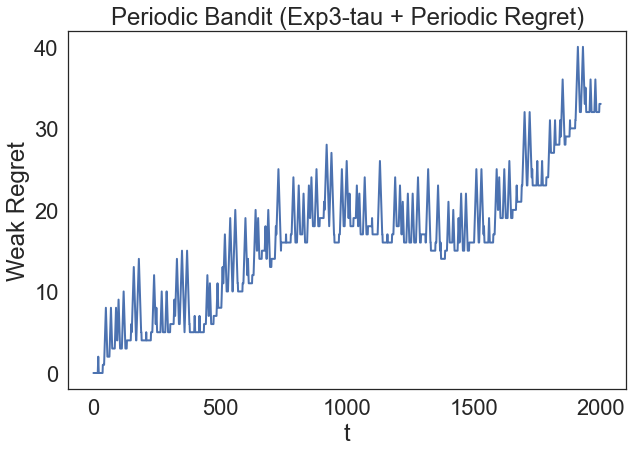

In [60]:
sns.set_theme(style="white", font_scale=2)
plt.figure(figsize=(10,6.6))
ax1 = sns.lineplot(x="t",y="regret",data=df, linewidth = 2)
ax1.set_title("Periodic Bandit (Exp3-tau + Periodic Regret)")
ax1.set_xlabel("t")
ax1.set_ylabel("Weak Regret")
ax1.figure.savefig("regret_periodic_2arm.png")

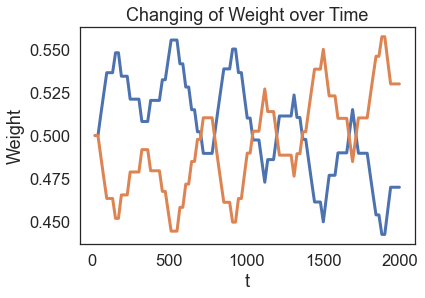

In [63]:
sns.set_theme(style="white", font_scale=1.5)
ax2 = sns.lineplot(x="t",y="weight",data=df_weight,hue="legend", linewidth = 3)
ax2.set_title("Changing of Weight over Time")
ax2.set_xlabel("t")
ax2.set_ylabel("Weight")
ax2.legend().remove()
ax2.figure.savefig("weight_periodic_2arm.png")

In [288]:
a=[]
costs_A, costs_B, costs_C, costs_exp3, costs_optimal = 0, 0, 0, 0, 0
actions_exp3 = df.action.values
for i in range(1,T+1):
    costs_A += costs[i][0]
    costs_B += costs[i][1]
    costs_C += costs[i][2]
    costs_exp3 += costs[i][actions_exp3[i-1]]
    costs_optimal += np.min(costs[i])
    a.append({"t": i, "costs": costs_A, "group": "A"})
    a.append({"t": i, "costs": costs_B, "group": "B"})
    a.append({"t": i, "costs": costs_C, "group": "C"})
    a.append({"t": i, "costs": costs_exp3, "group": "exp3"})
    a.append({"t": i, "costs": costs_optimal, "group": "optimal"})
df_costs=pd.DataFrame(a)

<AxesSubplot:xlabel='t', ylabel='costs'>

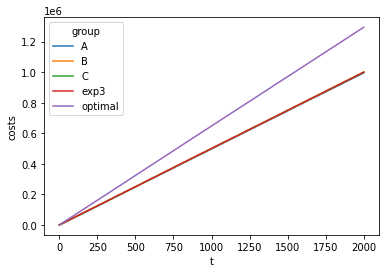

In [285]:
sns.lineplot(x="t", y="costs", data=df_costs, hue="group")

In [289]:
print(costs_A, costs_B, costs_C, costs_exp3, costs_optimal)

995314.624031258 999999.9999999998 1000000.0000000001 999147.528302416 705637.5112013351


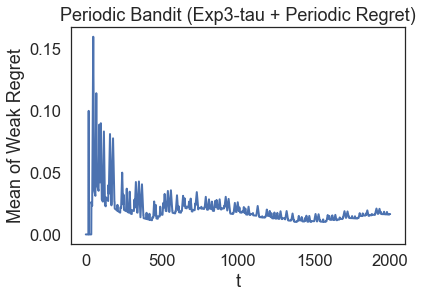

In [62]:
sns.set_theme(style="white", font_scale=1.5)
ax3 = sns.lineplot(x="t",y="regret_mean",data=df, linewidth = 2)
ax3.set_title("Periodic Bandit (Exp3-tau + Periodic Regret)")
ax3.set_xlabel("t")
ax3.set_ylabel("Mean of Weak Regret")
ax3.figure.savefig("mean_regret_periodic_2arm.png")